In [1]:
## General librairies
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import sys
import time
from copy import deepcopy


## Cosine Distance
from scipy.spatial.distance import cosine

import tensorflow as tf

## Keras utilities
import tensorflow.keras
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Lambda,  Dense, Flatten,MaxPooling2D,Dropout, UpSampling2D
# from tensorflow.keras.engine.input_layer import Input
# from tensorflow.keras.layers import merge
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.regularizers import l2
import numpy.random as rng
from sklearn.utils import shuffle

## Sklearn utilities
#### Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
#### Scores
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#### Feature transformations
import umap




## Removing some of the useless warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [2]:
# Some useful functions to ease the processings
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

def plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    x = list(range(len(acc)))
    plt.plot(x,acc)
    plt.plot(x,val_acc)
    
def cat_to_num(y):
    y1 = []
    for i in range(y.shape[0]):
        a = 0
        for j in range(y.shape[1]):
            a += j*y[i,j]
        y1.append(int(a))
    return y1

def generate_integer():
    
    ints = []
    
    while len(ints)<5:
        r = random.randint(0,63)
        if not(r in ints):
            ints.append(r)
    return ints

<Figure size 432x288 with 0 Axes>

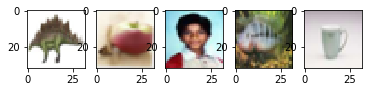

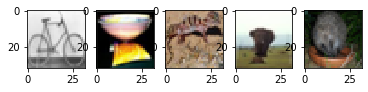

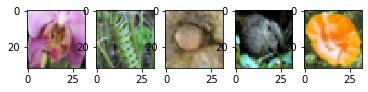

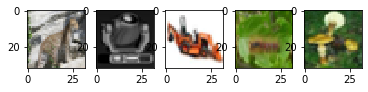

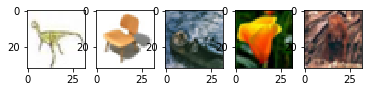

In [3]:
OT = load('training_set')

for i in range(5):
    plt.figure(i)
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
    ax1.imshow(OT['data'][600*i+1])
    ax2.imshow(OT['data'][600*i+2])    
    ax3.imshow(OT['data'][600*i+3])
    ax4.imshow(OT['data'][600*i+4])
    ax5.imshow(OT['data'][600*i+5])
    
Y_meta = OT['label']
X_meta = OT['data']

y_meta = np_utils.to_categorical(Y_meta)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

In [5]:
X_meta.shape

(38400, 32, 32, 3)

In [6]:
import resnet
build = resnet.ResnetBuilder()
model = build.build_resnet_12((32,32,3),64)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

# model.summary()



# score = model.evaluate(X_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

# save(history, '2.resnet2 with augmentation', 'results')
# save(model, '2.resnet2 with augmentation', 'model')
# plot(history)

In [9]:
optimizer = SGD(0.1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [13]:
import time
batch_size = 128
epochs = 2
t0 = time.time()
history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs)

t1 = time.time()
print(t1-t0)

  ...
    to  
  ['...']
Train for 240 steps, validate on 7680 samples
Epoch 1/2
240/240 [==============================] - 15s 61ms/step - loss: 3.1802 - accuracy: 0.3310 - val_loss: 3.2604 - val_accuracy: 0.3116
Epoch 2/2
240/240 [==============================] - 15s 61ms/step - loss: 3.0492 - accuracy: 0.3603 - val_loss: 3.0780 - val_accuracy: 0.3564
29.60575270652771


In [ ]:
save(model, 'resnet12', 'model')

In [ ]:
dir(model)

In [ ]:
model.save('resnet12.h5')

In [ ]:
m = tf.keras.models.load_model('resnet12.h5')

## Few shot evaluation

In [ ]:
OT1 = load('test_set')

from copy import deepcopy
Y_val = deepcopy(OT1['label'])
X_val = deepcopy(OT1['data'])


## Restructuring the images into an array of size 64*600*84*84*3 to ease the acces to a given class
tab = []
for i in range(36):
    tab.append([])

for i in range(len(Y_val)):
    tab[Y_val[i]-64].append(X_val[i])

X = np.array(tab)

In [ ]:
n = 5
k = 5


## A function in order to generate a random array of n distincts values between m and M
def choose_n_classes(n, m, M):
    tab = []
    while len(tab)<n:
        r = random.randint(m,M)
        if not(r in tab):
            tab.append(r)
    tab.sort()
    tab = np.array(tab)
    
    dico = {}
    for i in range(n):
        dico[tab[i]] = i
    
    return tab, dico


## A function to generate data ready for an experiment, tab and dico are here in order to repeat the experiment 
## on the same 5 classes, but with a different number of drawn sample in the class
def build_dataset(X, n,k,value = True, tab = True, dico = True):
    if value == True:
        tab, dico = choose_n_classes(n, 64,99)
    
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    
    print(dico)
    
    for elt in tab:
        ind, dico1 = choose_n_classes(k, 0, 600)
        ind1, dico2 = choose_n_classes(100, 0, 600)
        for i in range(600):
            if i in ind:
                x_train.append(X[elt-64,i])
                y_train.append(dico[elt])
#             elif i in ind1:
#                 x_test.append(X[elt-64,i])
#                 y_test.append(dico[elt])
            else:
                x_test.append(X[elt-64,i])
                y_test.append(dico[elt])
    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test), tab, dico

In [ ]:
model_transfert = tf.keras.models.load_model('resnet12.h5')

In [ ]:
model_transfert.summary()

In [ ]:
model_transfert = tf.keras.models.load_model('resnet12.h5')

inputs = model_transfert.input
outputs = model_transfert.get_layer('activation_10').output
outputs = Flatten()(outputs)
model = Model(inputs=inputs,   outputs=outputs)

In [ ]:
n = 5
k = 5

X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k)#, False, tab, dico)

for i in range(5):
    plt.figure(i)
    plt.imshow(X_train[k*i])

In [ ]:
y_test1 = np.zeros(y_test.shape[0])-1

Xt = model.predict(X_train)
print(0)
Xv = model.predict(X_test)
print(1)

clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', max_iter = 1000, penalty='l2')
clf.fit(Xt,y_train)
y_pred = clf.predict(Xv)

print(accuracy_score(y_test, y_pred))

y_learn = np.concatenate([y_train, y_test1])

In [ ]:
reducer = umap.UMAP(n_neighbors=12, metric='cosine', n_components=2)

y_test_unsupervised = np.zeros(y_test.shape[0])-1
y_learn = np.concatenate([y_train, y_test_unsupervised])

embedding = reducer.fit(np.concatenate([Xt1, Xv1], axis=0), y_learn)

Xt1 = embedding.transform(Xt1)
Xv1 = embedding.transform(Xv1)

In [ ]:
plt.figure(0)
plt.scatter(Xt1[:, 0], Xt1[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

plt.figure(1)
plt.scatter(Xv1[:, 0], Xv1[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

In [ ]:
Xt1.shape

In [ ]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)

clf.fit(Xt1,y_train)
y_pseudo = clf.predict(Xv1)

print(accuracy_score(y_test, y_pseudo))

In [ ]:
from cvae import cvae

In [ ]:
embedder = cvae.CompressionVAE(np.concatenate([Xt, Xv], axis=0))

In [ ]:
embedder.train()

In [ ]:
Xt1 = embedder.embed(Xt)
Xv1 = embedder.embed(Xv)

In [ ]:
plt.figure(0)
plt.scatter(Xt1[:, 0], Xt1[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

plt.figure(1)
plt.scatter(Xv1[:, 0], Xv1[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

In [ ]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)

clf.fit(Xt1,y_train)
y_pseudo = clf.predict(Xv1)

print(accuracy_score(y_test, y_pseudo))

In [ ]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)

clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))
y_pred = clf.predict(Xv)

print(accuracy_score(y_test, y_pred))

In [ ]:
scores = []
scores1 = []
scores2 = []
n = 5
k = 1

for i in range(300):
    print(i)
    X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k)
    
    ## First prediction for comparison
    Xt = model.predict(X_train)
    Xv = model.predict(X_test)
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.3)
    clf.fit(Xt,y_train)
    y_pred = clf.predict(Xv)
    print(accuracy_score(y_test, y_pred))
    
    a = accuracy_score(y_test, y_pred)
    scores.append(a)
    
    
    y_test_unsupervised = np.zeros(y_test.shape[0])-1
    y_learn = np.concatenate([y_train, y_test_unsupervised])
    
    ## Prediction with umap embedding
    reducer = umap.UMAP(n_neighbors=12, metric='cosine', n_components=30)
    embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)

    Xt1 = embedding.transform(Xt)
    Xv1 = embedding.transform(Xv)
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.3)
    clf.fit(Xt1,y_train)
    y_pseudo = clf.predict(Xv1)
    
    print(accuracy_score(y_test, y_pseudo))
    a = accuracy_score(y_test, y_pseudo)
    scores1.append(a)
    
    print(np.array(scores1).mean())
    ## Final prediction
#     clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)
#     clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))

#     y_pred = clf.predict(Xv)
#     accuracy_score(y_test, y_pred)
    
#     a = accuracy_score(y_test, y_pred)
#     print(a)
    
#     scores2.append(a)
    
print(np.array(scores).mean())
print(np.array(scores1).mean())
print(np.array(scores2).mean())